In [1]:
import numpy as np
import pandas as pd
from Bio import Phylo, SeqIO
from treetime import TreeAnc, GTR, GTR_site_specific, ASRV
import matplotlib.pyplot as plt
import seaborn as sns
import toytree
%matplotlib inline

In [2]:
path = '../data/'

In [3]:
def rename_ancestral_nodes(curr_tree):
    for node in curr_tree.tree.find_clades(order='postorder'):
        if len(node.clades) == 0:
            continue
        children_set = set([child.name for child in node.clades])
        if '01' in children_set and '02' in children_set:
            node.name = '37'
        elif '03' in children_set and '04' in children_set:
            node.name = '36'
        elif '05' in children_set and '06' in children_set:
            node.name = '35'
        elif '07' in children_set and '08' in children_set:
            node.name = '33'
        elif '09' in children_set and '10' in children_set:
            node.name = '31'
        elif '12' in children_set and '13' in children_set:
            node.name = '29'
        elif '14' in children_set and '15' in children_set:
            node.name = '27'
        elif '16' in children_set and '17' in children_set:
            node.name = '26'
        elif '18' in children_set and '19' in children_set:
            node.name = '25'
        elif '25' in children_set and '26' in children_set:
            node.name = '24'
        elif '24' in children_set and '27' in children_set:
            node.name = '23'
        elif '11' in children_set and '29' in children_set:
            node.name = '28'
        elif '23' in children_set and '28' in children_set:
            node.name = '22'
        elif '35' in children_set and '36' in children_set:
            node.name = '34'
        elif '33' in children_set and '34' in children_set:
            node.name = '32'
        elif '31' in children_set and '32' in children_set:
            node.name = '30'
        elif '22' in children_set and '30' in children_set:
            node.name = '21'
        elif '21' in children_set and '37' in children_set:
            node.name = '20'

In [4]:
# helper functions
def measure_accuracy(curr_tree, show_results=False):
    rename_ancestral_nodes(curr_tree)
    node_seq_dict = {}

    for node in curr_tree.tree.find_clades(order='preorder'):
        if node.name != 20:
            node_seq_dict[node.name] = node.sequence
            
    #import ground truth sequences
    true_node_seq_dict = {}
    record_dict = SeqIO.to_dict(SeqIO.parse(path+"fp_seq_aa.fasta", "fasta"))

    for name in node_seq_dict.keys():
        if name != '20':
            true_node_seq_dict[name] = np.array(record_dict[name].seq, dtype='U1')
    
    name_err = {}
    total_count = 0
    for name in true_node_seq_dict.keys():
        incorrect_count = ((node_seq_dict[name] == true_node_seq_dict[name]) == False).astype(int).sum()
        
        if int(name) > 20:
            name_err[name] = incorrect_count
        #print(name+':', incorrect_count)
        total_count += incorrect_count
    acc = 1 - total_count/(17*len(curr_tree.tree.root.sequence))
    
    if show_results:
        print(total_count)
        print('acccuracy:', 1 - total_count/(17*len(curr_tree.tree.root.sequence)))
    
    return total_count, acc, name_err


def sort_dict(dic):
    sorted_dict = []
    for key in sorted(dic.keys()):
        sorted_dict.append(dic[key])
        
    return sorted_dict

In [211]:
# EX properties ('B', 'E')
ex_properties = 'EEEEEEEBEEEBEBEBEBEEEBEEEEBEBEEEEEEEEEEBEEEBEEEBEEEEEBEBBBEBBBEBBEEEEEEBEEEEEEBEEEBEEEEEEEEEEEEEEEEEEEBEBEBEEEBEBEEEEBEEEBEBEBEEEEEEEEEBEEEEEEEEEEEEEEEEEEEEBEBEBEEEBEBEEEEEEEBEBEEEEEBEEEEEEEEEBBBEEEBEEEEEEEEEEEEEEEEEBEBEEEEEE'
solvent_property = np.array(list(ex_properties))

# EHO properties ('H', 'E', 'O')
eho_properties = 'CCCCHHHCCCCCEEEEEEECCCCCCEEEEEECCCCCCCCCEEEEEEEEECCCCCCCCHHHHHHHHHHCCCEECCCCCCCHHHHHHHCCCCCEEEEEEEECCCCEEEEEEEEEECCCEEEEEEEEEECCCCCCCCCCCCCCCCCCCCCCCEECCCCEEEEEEEEEEEECCCCEEEEEEEEEEECCCCCCCCCCEEEEEEEEEECCCCCCCEEEEEEEEEEEECCCC'
eho_properties_formatted = eho_properties.replace('C', 'O')
secondary_property = np.array(list(eho_properties_formatted))


In [6]:
alpha=0.545
asrv = ASRV(alpha)
rates = asrv.calc_rates()

### Test site-specific gtr

In [ ]:
fp_tree = TreeAnc(compress=False, gtr='BE', tree=path+'fp_tree.nwk', aln=path+'fp_extant_aa.fasta', rates=rates,
                  struct_propty=solvent_property, verbose=0)
fp_tree.infer_ancestral_sequences(infer_gtr=False, marginal=True)
_ = measure_accuracy(fp_tree, show_results=True)

In [ ]:
# plot the distribution and fitted gamma distribution
from scipy.stats import gamma

x = np.linspace(0, 10, 100)
alpha_plot = 0.003
scale = 1/alpha_plot
y = gamma.pdf(x, a=alpha_plot, scale=1000000000)

plt.bar(num_variants.keys(), num_variants.values(), 1, alpha=0.5, color='b')
plt.plot(x,y)
plt.show()

In [ ]:
# fine tuning
alpha_vals = np.linspace(0.01, 1.5, 100)

error_counts = []
accs = []
error_counts_ss = []
accs_ss = []

for i, a in enumerate(alpha_vals):
    if i % 10 == 0:
        print('--- ROUND %d ---' % (i))
    asrv = ASRV(a)
    curr_rates = asrv.calc_rates()
    
    fp_tree = TreeAnc(compress=False, gtr='BE', tree=path+'fp_tree.nwk', aln=path+'fp_extant_aa.fasta', 
                      rates=curr_rates, struct_propty=solvent_property, verbose=0)
    fp_tree.infer_ancestral_sequences(infer_gtr=False, marginal=True)
    
    count, acc, _ = measure_accuracy(fp_tree)
    error_counts.append(count)
    accs.append(acc)
    
    
    fp_tree_ss = TreeAnc(compress=False, gtr='EX', tree=path+'fp_tree.nwk', aln=path+'fp_extant_aa.fasta',
                      rates=curr_rates, struct_propty=solvent_property, verbose=0)
    fp_tree_ss.infer_ancestral_sequences(infer_gtr=False, marginal=True)
    
    count_ss, acc_ss, _ = measure_accuracy(fp_tree_ss)
    error_counts_ss.append(count_ss)
    accs_ss.append(acc_ss)

    del asrv, curr_rates, fp_tree, fp_tree_ss




In [ ]:
fp_tree_invariant = TreeAnc(compress=False, gtr='BE',
                           tree=path + 'fp_tree.nwk',
                           rates=rates,
                           aln=path+'fp_extant_aa.fasta',
                           struct_propty=solvent_property,
                           mu=mus,
                           verbose=0)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(alpha_vals, accs)
plt.plot(alpha_vals, accs_ss)
plt.show()

In [ ]:
fp_tree_ss.gtr[]

In [ ]:
del fp_tree, fp_tree_ss

### Test loglikelihood

In [322]:
alpha=0.545
asrv = ASRV(alpha)
rates = asrv.calc_rates()

In [323]:
fp_tree_comparison = TreeAnc(compress=False, gtr='lg', tree=path+'fp_tree.nwk', aln=path+'fp_extant_aa.fasta', verbose=0)
fp_tree = TreeAnc(compress=False, gtr='wag', tree=path+'fp_tree.nwk', aln=path+'fp_extant_aa.fasta', verbose=0)
fp_tree_asrv = TreeAnc(compress=False, gtr='wag', tree=path+'fp_tree.nwk', aln=path+'fp_extant_aa.fasta', rates=rates, verbose=0)
fp_tree_ss = TreeAnc(compress=False, gtr='EX', tree=path+'fp_tree.nwk', aln=path+'fp_extant_aa.fasta', rates=rates,
                  struct_propty=solvent_property, verbose=0)
fp_tree_3d = TreeAnc(compress=False, gtr='EHO', tree=path+'fp_tree.nwk', aln=path+'fp_extant_aa.fasta', rates=rates,
                  struct_propty=secondary_property, verbose=0)


#_,_, secondary_profile = measure_accuracy(fp_tree)

#secondary_lhs = fp_tree.tree.sequence_LH
fp_tree_comparison.infer_ancestral_sequences(infer_gtrs=False, marginal=True)
fp_tree.infer_ancestral_sequences(infer_gtrs=False, marginal=True)
fp_tree_asrv.infer_ancestral_sequences(infer_gtrs=False, marginal=True)
fp_tree_ss.infer_ancestral_sequences(infer_gtrs=False, marginal=True)
fp_tree_3d.infer_ancestral_sequences(infer_gtrs=False, marginal=True)


_, _, lg_profile = measure_accuracy(fp_tree_comparison, show_results=True)
_, _, wag_profile= measure_accuracy(fp_tree, show_results=True)
_, _, wag_asrv_profile = measure_accuracy(fp_tree_asrv, show_results=True)
_, _, wag_ss_profile = measure_accuracy(fp_tree_ss, show_results=True)
_, _, wag_3d_profile = measure_accuracy(fp_tree_3d, show_results=True)


# cleaning
#del fp_tree

77
acccuracy: 0.9798692810457517
79
acccuracy: 0.9793464052287582
79
acccuracy: 0.9793464052287582
75
acccuracy: 0.9803921568627451
82
acccuracy: 0.978562091503268


In [214]:
print(fp_tree_comparison.tree.total_sequence_LH)
print(fp_tree.tree.total_sequence_LH)
print(fp_tree_asrv.tree.total_sequence_LH)
print(fp_tree_ss.tree.total_sequence_LH)
print(fp_tree_3d.tree.total_sequence_LH)

-2994.8687627508634
-2918.527325878265
-2802.1603594401695
-2898.265179102712
-2938.5143504347734


In [227]:
#fp_fix = fp_tree.tree.sequence_LH - fp_tree_comparison.tree.sequence_LH
#fp_asrv = fp_tree_asrv.tree.sequence_LH - fp_tree_comparison.tree.sequence_LH
#fp_ss = fp_tree_ss.tree.sequence_LH - fp_tree_comparison.tree.sequence_LH
#fp_3d = fp_tree_ss.tree.sequence_LH - fp_tree_comparison.tree.sequence_LH

fp_fix = fp_tree.tree.sequence_LH
fp_asrv = fp_tree_asrv.tree.sequence_LH
fp_ss = fp_tree_ss.tree.sequence_LH
fp_3d = fp_tree_ss.tree.sequence_LH


In [228]:
fp_vals = np.zeros(4* len(fp_fix)) 
fp_vals[:len(fp_fix)] = fp_fix
fp_vals[len(fp_fix):2*len(fp_fix)] = fp_asrv
fp_vals[2*len(fp_fix):3*len(fp_fix)] = fp_ss
fp_vals[3*len(fp_fix):] = fp_3d

In [229]:
method = ['Fixed (without Γ)'] * len(fp_fix) + ['ASRV (Γ)'] * len(fp_asrv) + ['Solvent + Γ'] * len(fp_asrv) + ['Secondary + Γ'] * len(fp_asrv)
df = pd.DataFrame.from_dict({'Loglikelihood': fp_vals, 'Method': method})

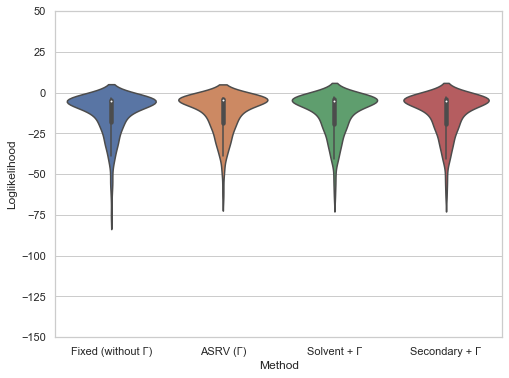

In [231]:
plt.figure(figsize=(8,6))
sns.violinplot(x='Method', y='Loglikelihood', data=df)
plt.ylim([-150, 50])
plt.savefig('Loglikelihood_fp.png', dpi=300)

In [ ]:
# fine tuning
#count_wag = []
#accs_wag = []

#alpha_vals = np.linspace(0.01, 1.5, 100)

#for i, a in enumerate(alpha_vals):
#    if i % 10 == 0:
#        print('--- ROUND %d ---' % (i)) 
#    asrv = ASRV(a)
#    rates = asrv.calc_rates()
#    
#    fp_tree = TreeAnc(compress=False, gtr='wag', tree=path+'fp_tree.nwk', aln=path+'fp_extant_aa.fasta', rates=rates, verbose=0)
#    fp_tree.infer_ancestral_sequences(infer_gtrs=False, marginal=True)
#    count, acc, _ = measure_accuracy(fp_tree)
    
#    count_wag.append(count)
#    accs_wag.append(count)

#    del count, acc, fp_tree

### Grouped barplot 

In [245]:
#jtt_profile = sort_dict(jtt_profile)
wag_profile = sort_dict(wag_profile)
wag_profile_asrv = sort_dict(wag_asrv_profile)
solvent_profile = sort_dict(wag_ss_profile)
secondary_profile = sort_dict(wag_3d_profile)



In [250]:
fastml_profile = [10,8,2,1,8,0,2,5,1,8,6,4,4,4,2,2,3]

In [251]:
colors = sns.color_palette("Set2", 8)

In [252]:
colors = colors[:5]

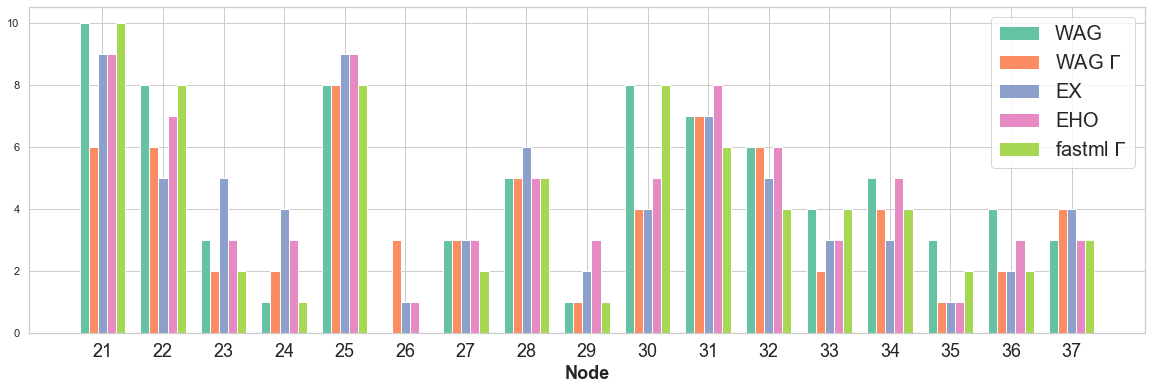

In [261]:
barWidth = 0.15

r1 = np.arange(17)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
#r5 = [x + barWidth for x in r4]
#r6 = [x + barWidth for x in r5]
#r7 = [x + barWidth for x in r6]
#r8 = [x + barWidth for x in r7]

""""
plt.figure(figsize=(30, 8))
plt.bar(r1, jtt_profile, color=colors[0], width=barWidth, edgecolor='white', label='JTT')
plt.bar(r2, wag_profile, color=colors[1], width=barWidth, edgecolor='white', label='WAG')
plt.bar(r3, lg_profile, color=colors[2], width=barWidth, edgecolor='white', label='LG')
plt.bar(r4, jtt_profile_asrv, color=colors[3], width=barWidth, edgecolor='white', label='JTT $\Gamma$')
plt.bar(r5, wag_profile_asrv, color=colors[4], width=barWidth, edgecolor='white', label='WAG $\Gamma$')
plt.bar(r6, lg_profile_asrv, color=colors[5], width=barWidth, edgecolor='white', label='LG $\Gamma$')
plt.bar(r7, solvent_profile, color=colors[6], width=barWidth, edgecolor='white', label='Solvent')
plt.bar(r8, structural_profile, color=colors[7], width=barWidth, edgecolor='white', label='Secondary')
"""

plt.figure(figsize=(20,6))
plt.bar(r1, wag_profile, color=colors[0], width=barWidth, edgecolor='white', label='WAG')
plt.bar(r2, wag_profile_asrv, color=colors[1], width=barWidth, edgecolor='white', label='WAG $\Gamma$')
plt.bar(r3, solvent_profile, color=colors[2], width=barWidth, edgecolor='white', label='EX')
plt.bar(r4, secondary_profile, color=colors[3], width=barWidth, edgecolor='white', label='EHO')
plt.bar(r5, fastml_profile, color=colors[4], width=barWidth, edgecolor='white', label='fastml $\Gamma$')



plt.xlabel('Node', fontweight='bold', fontsize=18)
plt.xticks([r + 0.3 for r in range(17)], [str(i) for i in range(21, 38)], fontsize=18)
plt.legend(prop={'size': 20})
plt.savefig('bar_incorrect.png', dpi=300)
plt.show()

### Compare loglikelihood

In [ ]:
# matrices
matrices = ['jtt92', 'wag01','lg08']
alpha = 0.542

In [ ]:
jtt_lhs = []
wag_lhs = []
lg_lhs = []
ex_lhs = []
eho_lhs = []

In [ ]:
counts = [80, 79, 77, 80, 79, 79, 75, 82]
accs_asrv = [0.9790849673202614, 0.9793464052287582, 0.9798692810457517, 0.9790849673202614, 0.9793464052287582, 0.9793464052287582, 0.9803921568627451, 0.978562091503268]

In [ ]:
len(jtt_lhs)

In [ ]:
## violinplot
catg_list = []
category = ['JTT', 'WAG', 'LG', 'JTT Γ', 'WAG Γ', 'LG Γ', 'Solvent Acc.', 'Secondary']

for catg in category[:-2]:
    catg_list.extend([catg] * 127)
catg_list.extend(['Solvent'] * 255)
catg_list.extend(['Secondary'] * 255)

lh_list = [jtt_lhs, wag_lhs, lg_lhs, jtt_lhs_asrv, wag_lhs_asrv, lg_lhs_asrv, solvent_lhs, secondary_lhs]
lh_vals = []

for lh in lh_list:
    lh_vals.extend(lh)

In [ ]:
df = pd.DataFrame(list(zip(lh_vals, catg_list)), 
               columns =['lh', 'model'])

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(x='model', y='lh', data=df)
plt.suptitle('Loglikelihood comparison between models')
plt.savefig('Loglikelihood.png', dpi=300)

In [ ]:
lh_vals_new = []
for lh in lh_list[1:6]:
    lh_vals_new.extend(lh - jtt_lhs)

In [ ]:
#lh_vals_new.extend(solvent_lhs[:len(jtt_lhs)] - jtt_lhs)
#lh_vals_new.extend(secondary_lhs[:len(jtt_lhs)] - jtt_lhs)

In [ ]:
df_new = pd.DataFrame(list(zip(lh_vals_new, catg_list[127:-510])), 
               columns =['lh', 'model'])

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(x='model', y='lh', data=df_new)
plt.suptitle('Loglikelihood comparison between models')
plt.savefig('Loglikelihood_2.png', dpi=300)

### Mitochondrial sequence

In [ ]:
# filter
species_names = set()
seq_titles = set()
with open(path + 'mito_cos.fasta', 'r') as ifile:
    for line in ifile:
        if line[0] == '>':
            species_name = line.partition('[')[2].partition(']')[0]
            if species_name not in species_names:
                species_names.add(species_name)
            else:
                print(species_name)

            

In [ ]:
len(species_names)

In [ ]:
%%bash
ls -al ../data

In [187]:
asrv = ASRV(0.26)
rates = asrv.calc_rates()

In [188]:
mito_solvent_tmp = '22413310210010110210010000000000000000000000101301211323100000000000000000000000000000000000000100001011000000000000000010023111100000000112211211000000000000000000000000000100214304133000000000000000000000000000000011201110010111110000000000011110000000000000000132233431001000000000000000000000000000101010000000000001010100000000100303130000000000000000100000001010100011000000001000000000000000000001001130242102000000000010000010000011001112200100110100000000000000000000000001242211013221100000231112210131102034455523233'
mito_solvent_properties = np.array(list(mito_solvent_tmp), dtype='U1')
buried_sites = mito_solvent_properties == '0'
exposed_sites = mito_solvent_properties != '0'
mito_solvent_properties[buried_sites] = 'B'
mito_solvent_properties[exposed_sites] = 'E'

In [189]:
mito_secondary_tmp = 'CCCCCHHHHEEEECCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCEEHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCHHHHCCHHHHHHHHHHHHCCCCCCCEECCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCHHHHHHHHHHCCCCCEEEEECCCCHHHHHHHHCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHCCCEEECCCHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHCCCECCCHHHHHHHHHHHHHHCCCCCEEEECCCCCCEECCCCEEEHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCECCCCCCCCHHHHCCCCCCCCCCCCCCEEECCCCCCCCCC'
mito_secondary_properties = np.array(list(mito_secondary_tmp), dtype='U1')
mito_secondary_properties[mito_secondary_properties == 'C'] = 'O'

In [190]:
mito_tree_comparison = TreeAnc(compress=False, gtr='lg', tree=path+'mito_cos_raxml_tree.nwk', aln=path+'mito_cos_aln.fasta', verbose=0)
mito_tree_comparison.infer_ancestral_sequences(infer_gtr=False, marginal=True)


mito_tree = TreeAnc(compress=False, gtr='wag', tree=path+'mito_cos_raxml_tree.nwk', aln=path+'mito_cos_aln.fasta', verbose=0)
mito_tree.infer_ancestral_sequences(infer_gtr=False, marginal=True)

mito_tree_asrv = TreeAnc(compress=False, gtr='wag', tree=path+'mito_cos_raxml_tree.nwk', aln=path+'mito_cos_aln.fasta', 
                    rates=rates, verbose=0)
mito_tree_asrv.infer_ancestral_sequences(infer_gtr=False, marginal=True)


mito_tree_ss = TreeAnc(compress=False, gtr='EX', tree=path+'mito_cos_raxml_tree.nwk', aln=path+'mito_cos_aln.fasta', 
                    rates=rates, struct_propty=mito_solvent_properties, verbose=0)
mito_tree_ss.infer_ancestral_sequences(infer_gtr=False, marginal=True)

mito_tree_3d = TreeAnc(compress=False, gtr='EHO', tree=path+'mito_cos_raxml_tree.nwk', aln=path+'mito_cos_aln.fasta', 
                    rates=rates, struct_propty=mito_secondary_properties, verbose=0)
mito_tree_3d.infer_ancestral_sequences(infer_gtr=False, marginal=True)

0

In [191]:
print(mito_tree_comparison.tree.sequence_LH.sum())
print(mito_tree.tree.sequence_LH.sum())
print(mito_tree_asrv.tree.sequence_LH.sum())
print(mito_tree_ss.tree.sequence_LH.sum())
print(mito_tree_3d.tree.sequence_LH.sum())

-7339.513520589013
-7204.332155021682
-6576.548828608871
-6747.659587511436
-6884.197109187369


In [198]:
#mito_fix = mito_tree.tree.sequence_LH - mito_tree_comparison.tree.sequence_LH
#mito_asrv = mito_tree_asrv.tree.sequence_LH - mito_tree_comparison.tree.sequence_LH
#mito_ss = mito_tree_ss.tree.sequence_LH - mito_tree_comparison.tree.sequence_LH
#mito_3d = mito_tree_3d.tree.sequence_LH - mito_tree_comparison.tree.sequence_LH

mito_fix = mito_tree.tree.sequence_LH
mito_asrv = mito_tree_asrv.tree.sequence_LH 
mito_ss = mito_tree_ss.tree.sequence_LH 
mito_3d = mito_tree_3d.tree.sequence_LH 
mito_vals = np.zeros(4*len(mito_fix)) 
mito_vals[:len(mito_fix)] = mito_fix
mito_vals[len(mito_fix):2*len(mito_fix)] = mito_asrv
mito_vals[2*len(mito_fix):3*len(mito_fix)] = mito_ss
mito_vals[3*len(mito_fix):4*len(mito_fix)] = mito_3d

In [199]:
method = ['Fixed (without Γ)'] * len(mito_fix) + ['ASRV (Γ)'] * len(mito_asrv) + \
        ['Solvent + Γ'] * len(mito_asrv) + ['Secondary + Γ'] * len(mito_asrv)

In [200]:
df = pd.DataFrame.from_dict({'Loglikelihood': mito_vals, 'Method': method})

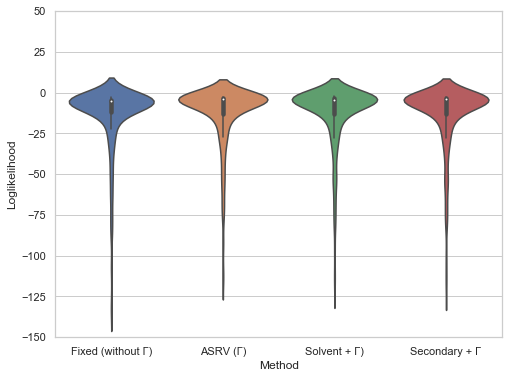

In [201]:
plt.figure(figsize=(8,6))
ax = sns.violinplot(x="Method", y="Loglikelihood", data=df)
plt.ylim([-150, 50])
plt.savefig('loglikehood_mito_cyto_without_lg.png', dpi=300)
plt.show()

In [345]:
tmp = mito_tree_3d.tree.sequence_LH - mito_tree.tree.sequence_LH
tmp[tmp < 0].astype(bool).sum()

218

In [ ]:
# Homo sapien aligned sequence -- for Sable analysis
for node in mito_tree.tree.find_clades(order='preorder'):
    if 'AAK17209.1' in node.name:
        print("".join(node.cseq))

In [202]:
mito_tree.tree.total_branch_length()

1.7144410065349796

### NADH 5

In [281]:
asrv = ASRV(1)
rates = asrv.calc_rates()

In [282]:
# solvent properties
nadh_solvent_tmp = '4420120000000000000000000121233212210000000000000000000011332000100100112103010000000000000000000000000001100331331210000000000000000002000000000100000000000000212301300010000000000000000000010020010110010122100000000000000100101001000100111100000010000000000000001100220310000000000000000000000221011000000001000000000001110000000000001000000000000003231101201101330100000000000000000000001011100000012110000000000000000000000000001132323423313232110000000000000000000010001122110002110000000000000000000011123133432211110010000011001200021001001200121011000110012000100110220121031101000000000000000000'
nadh_solvent_properties = np.array(list(nadh_solvent_tmp), dtype='U1')
nadh_buried_sites = nadh_solvent_properties == '0'
nadh_exposed_sites = nadh_solvent_properties != '0'
nadh_solvent_properties[nadh_buried_sites] = 'B'
nadh_solvent_properties[nadh_exposed_sites] = 'E'

In [283]:
# secondary properties
nadh_secondary_tmp = 'CCCHHHHHHHHHHHHHHHHHHHHHHCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHCCCCEEEEEEEEEECCCCEEEEEEEECCHHHHHHHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHHCHHHHHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHCCCHHHHHHHHHHHHHHCCCCCCCCCHHHHHHHCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHHCHHHHHCHHHHHHHHHHHHHHHCCCCCCCCCHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCEEECCHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH'
nadh_secondary_properties = np.array(list(nadh_secondary_tmp), dtype='U1')
nadh_secondary_properties[nadh_secondary_properties == 'C'] = 'O'

In [284]:
len(nadh_secondary_properties)

604

In [285]:
nadh_tree_comparison = TreeAnc(compress=False, gtr='lg', tree=path+'nadh_raxml_tree.nwk', aln=path+'nadh_aln.fasta', verbose=0)
nadh_tree_comparison.infer_ancestral_sequences(infer_gtr=False, marginal=True)


nadh_tree = TreeAnc(compress=False, gtr='wag', tree=path+'nadh_raxml_tree.nwk', aln=path+'nadh_aln.fasta', verbose=0)
nadh_tree.infer_ancestral_sequences(infer_gtr=False, marginal=True)

nadh_tree_asrv = TreeAnc(compress=False, gtr='wag', tree=path+'nadh_raxml_tree.nwk', aln=path+'nadh_aln.fasta', 
                    rates=rates, verbose=0)
nadh_tree_asrv.infer_ancestral_sequences(infer_gtr=False, marginal=True)


nadh_tree_ss = TreeAnc(compress=False, gtr='EX', tree=path+'nadh_raxml_tree.nwk', aln=path+'nadh_aln.fasta', 
                    rates=rates, struct_propty=nadh_solvent_properties, verbose=0)
nadh_tree_ss.infer_ancestral_sequences(infer_gtr=False, marginal=True)

nadh_tree_3d = TreeAnc(compress=False, gtr='EX', tree=path+'nadh_raxml_tree.nwk', aln=path+'nadh_aln.fasta', 
                    rates=rates, struct_propty=nadh_secondary_properties, verbose=0)
nadh_tree_3d.infer_ancestral_sequences(infer_gtr=False, marginal=True)

0

In [306]:
print(nadh_tree.tree.total_sequence_LH)
print(nadh_tree_asrv.tree.total_sequence_LH)
print(nadh_tree_ss.tree.total_sequence_LH)
print(nadh_tree_3d.tree.total_sequence_LH)

-19889.901083119035
-18523.829795718248
-19234.10686830979
-19439.741287041914


In [312]:
nadh_fix = nadh_tree.tree.sequence_LH - nadh_tree_comparison.tree.sequence_LH 
nadh_asrv = nadh_tree_asrv.tree.sequence_LH - nadh_tree_comparison.tree.sequence_LH 
nadh_ss = nadh_tree_ss.tree.sequence_LH - nadh_tree_comparison.tree.sequence_LH 
nadh_3d = nadh_tree_3d.tree.sequence_LH- nadh_tree_comparison.tree.sequence_LH 

nadh_vals = np.zeros(4*len(nadh_fix)) 
nadh_vals[:len(nadh_fix)] = nadh_fix
nadh_vals[len(nadh_fix):2*len(nadh_fix)] = nadh_asrv
nadh_vals[2*len(nadh_fix):3*len(nadh_fix)] = nadh_ss
nadh_vals[3*len(nadh_fix):4*len(nadh_fix)] = nadh_3d

In [313]:
method = ['Fixed (without Γ)'] * len(nadh_fix) + ['ASRV (Γ)'] * len(nadh_asrv) + \
        ['Solvent + Γ'] * len(nadh_asrv) + ['Secondary + Γ'] * len(nadh_asrv)

In [314]:
df = pd.DataFrame.from_dict({'Loglikelihood': nadh_vals, 'Method': method})

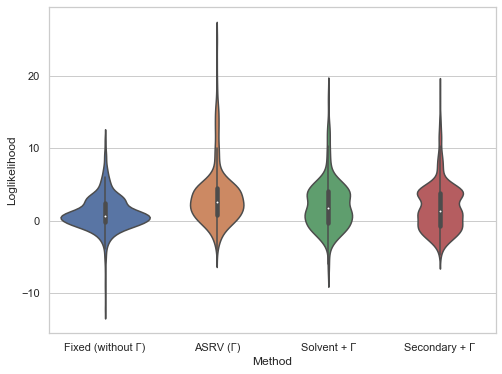

In [315]:
plt.figure(figsize=(8,6))
ax = sns.violinplot(x="Method", y="Loglikelihood", data=df)
#plt.ylim([-200, 50])
plt.savefig('loglikehood_nadh.png', dpi=300)
plt.show()

In [319]:
nadh_tree.tree.total_branch_length()

5.060585083910803

In [351]:
tmp = nadh_tree_asrv.tree.sequence_LH - nadh_tree.tree.sequence_LH
tmp[tmp > 0].astype(bool).sum()

440

In [239]:
for node in nadh_tree.tree.find_clades(order='preorder'):
    if node.name == 'AAK17672.1':
        print(''.join(node.cseq))

MNTMHTTMTTLTLTSLIPPILTTLVNPNKKNSYPHYVKSIVASTFIISLFPTTMFMCLDQEVIISNWHWATTQTTQLSLSFKLDYFSMMFIPVALFVTWSIMEFSLWYMNSDPNINQFFKYLLIFLITMLILVTANNLFQLFIGWEGVGIMSFLLISWWYARADANTAAIQAILYNRIGDIGFILALAWFILHSNSWDPQQMALLNANPSLTPLLGLLLAAAGKSAQLGLHPWLPSAMEGPTPVSALLHSSTMVVAGVFLLIRFHPLAENSPLIQTLTLCLGAITTLFAAVCALTQNDIKKIVAFSTSSQLGLMVVTIGINQPHLAFLHICTHAFFKAMLFMCSGSIIHNLNNEQDIRKMGGLLKTMPLTSTSLTIGSLALAGMPFLTGFYSKDHIIETANMSYTNAWALSITLIATSLTSAYSTRMILLTLTGQPRFPTLTNINENNPTLLNPIKRLAAGSLFAGFLITNNISPASPFQTTIPLYLKLTALAVTFLGLLTALDLNYLTNKLKMKSPLCTFYFSNMLGFYPSITHRTIPYLGLLTSQNLPLLLLDLTWLEKLLPKTISQHQISTSIITSTQKGMIKLYFLSFFFPLILTLLLIT


### Joint reconstruction time benchmark

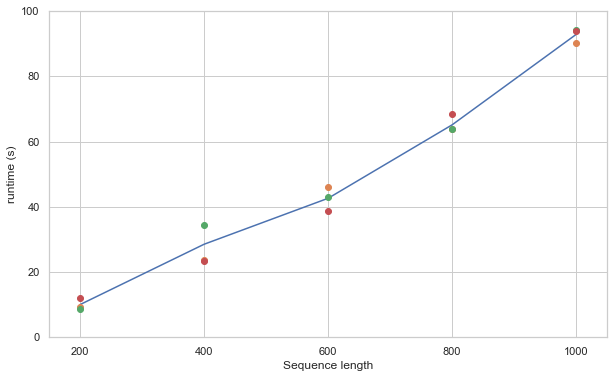

In [337]:
seq_len = [200, 400, 600, 800, 1000]
rt = [10.025, 28.519, 42.608, 65.127, 92.842]
rt1 = [9.397, 23.672, 46.078, 63.954, 90.211]
rt2 = [8.676, 34.509, 43.019, 63.899, 94.355]
rt3 = [12.003, 23.377, 38.729, 68.527, 93.962]

plt.figure(figsize=(10, 6))
plt.plot(seq_len, rt, '-')
plt.plot(seq_len, rt1, 'o')
plt.plot(seq_len, rt2, 'o')
plt.plot(seq_len, rt3, 'o')
plt.xticks([200, 400, 600, 800, 1000])
plt.xlim([150, 1050])
plt.ylim([0, 100])
plt.xlabel('Sequence length')
plt.ylabel('runtime (s)')
plt.savefig('benchmark joint.png', dpi=300)
plt.show()